## ***Add this to yolov7 folder to work !!***

# Data preprocessing

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import torch
from models.experimental import attempt_load
from utils.general import non_max_suppression, xyxy2xywh
from utils.torch_utils import time_synchronized

c:\Users\Mouad\anaconda3\envs\GTAVSelfDrivingCarSupervisedAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../../frameRecorder/data.csv')

In [3]:
df.head()

,image_id,q,z,s,d,no_key
0,1678573240597,0,0,0,0,1
1,1678573240656,0,0,0,0,1
2,1678573240706,0,0,0,0,1
3,1678573240753,0,0,0,0,1
4,1678573240803,0,1,0,0,0


In [4]:
# set device (if cuda is available use it)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Load model
model = attempt_load('yolov7.pt', map_location=device)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


In [6]:
# Set parameters
img_size = 256
conf_thres = 0.25

In [7]:
def detect_objects_per_frame(frame):
    # Resize image
    img = cv.resize(frame, (img_size, img_size))
    img = img.transpose(2, 0, 1)  # HWC to CHW
    img = torch.from_numpy(img).to(device).float()
    img /= 255.0

    # Detect objects
    t1 = time_synchronized()
    pred = model(img.unsqueeze(0))[0]
    pred = non_max_suppression(pred, conf_thres)
    t2 = time_synchronized()

    # Process detections
    objs = {}
    for i, det in enumerate(pred):
        # Rescale detection coordinates
        if det is not None and len(det):

            # getting the x, y coordinates with the width and height and drawing the boxes
            for *xyxy, conf, cls in reversed(det):
                x, y, w, h = xyxy2xywh(torch.tensor(xyxy).view(1, 4)).squeeze(0)
                xx, yy, ww, hh = (x / img_size) * frame.shape[1], (y / img_size) * frame.shape[0], (w / img_size) * frame.shape[1], (h / img_size) * frame.shape[0]
                label = f'{model.names[int(cls)]} {conf:.2f}'
                objs[label] = [xx, yy, ww, hh]
                cv.rectangle(frame, (int(xx - ww / 2), int(yy - hh / 2)), (int(xx - ww / 2 + ww), int(yy - hh / 2 + hh)), (255, 255, 0), 2)
                cv.putText(frame, label, (int(xx - ww / 2), int(yy - h / 2) - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

    return (objs, frame, t1, t2)

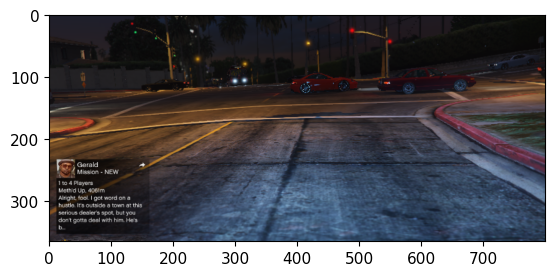

In [46]:
# Load image
temp = df.iloc[1000]['image_id']
img0 = cv.imread(f'../../frameRecorder/screenShots/{temp}.png')  # BGR
img0 = cv.cvtColor(img0, cv.COLOR_BGR2RGB)

# crop unnecessary data (this will change for other tasks, currently we only need to detect objects on the road) 
img0 = img0[120:485, :]


%matplotlib inline
plt.imshow(img0)

In [47]:
# detect objects using the funtction and get the new frame, the coordinates of the objects and the time needed for the prediction only not the whole function
objectss, nframe, t1, t2 = detect_objects_per_frame(img0)

truck 0.28: [752.3671875, 77.31671905517578, 88.70658874511719, 26.972515106201172, ]
car 0.35: [5.870063781738281, 131.88262939453125, 12.215919494628906, 29.36614227294922, ]
car 0.63: [750.7014770507812, 76.68833923339844, 88.55772399902344, 27.17623519897461, ]
car 0.66: [185.7230682373047, 114.44107055664062, 73.83097076416016, 20.136245727539062, ]
car 0.86: [442.25225830078125, 111.0760498046875, 111.6699447631836, 33.884124755859375, ]
car 0.87: [609.8594970703125, 107.40530395507812, 163.71240234375, 42.281124114990234, ]
0.30824708938598633


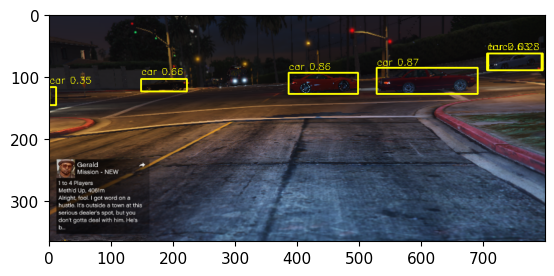

In [48]:
# print the dictionary of objects and informations about their coordinates
for k, v in objectss.items():
    print(f'{k}: ', end="[")
    for i in v:
        print(f'{i}', end=", ")
    print("]")

# print time needed only for detection (this might change a lot if we use cuda instead of the CPU)
print(t2 - t1)

%matplotlib inline
plt.imshow(nframe)